In [ ]:
from qiskit import IBMQ
IBMQ.save_account('a23dd50e78b92792960bae0815e30bf2d61f648cb0bb8fc6eb8bb9227c0172fa7383b64f86afd7c9e804dd00f23798bf8d2c1e67e5c90af2ed8461f40a72c36c')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_manila')

In [ ]:
import numpy as np

In [ ]:
backend_config = backend.configuration()
dt = backend_config.dt
backend_defaults = backend.defaults()

In [ ]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

In [ ]:
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

def get_closest_multiple_of(vaule, base_number):
    return int(vaule + base_number/2) - (int(vaule + base_number/2) % base_number)

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

In [ ]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate

# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.015 * us                           # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # This is a truncating parameter, because gaussians don't have 
                                                        # a natural finite length
drive_amp = 0.05

# Create the base schedule
# Start with drive pulse acting on the drive channel
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)

In [ ]:
sweep_gate = Gate("sweep", 1, [freq])

qc_sweep = QuantumCircuit(1, 1)

qc_sweep.append(sweep_gate, [0])
qc_sweep.x(0)
qc_sweep.x(0)
qc_sweep.measure(0, 0)
qc_sweep.add_calibration(sweep_gate, (0,), sweep_sched, [freq])

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

In [ ]:
exp_sweep_circs[0].draw()

In [ ]:
from qiskit import schedule

sweep_schedule = schedule(exp_sweep_circs[0], backend)
sweep_schedule.draw(backend=backend)

<IPython.core.display.Javascript object>


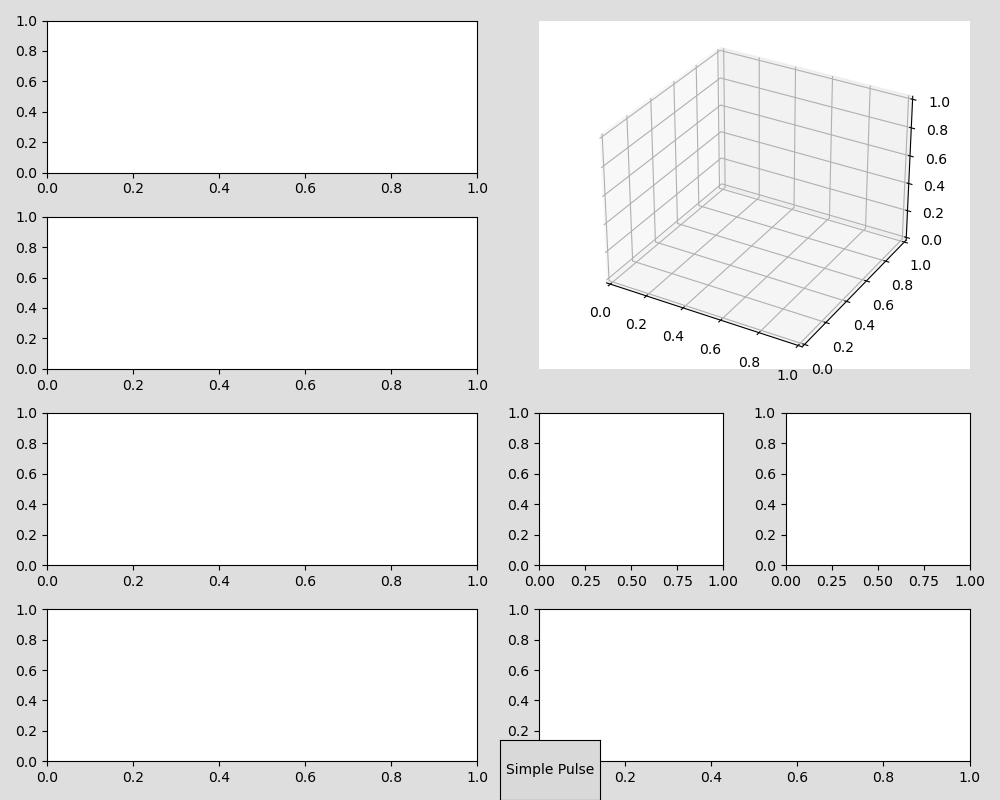

NameError: name 'callback' is not defined

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import collections
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import time
import threading
from matplotlib.widgets import Button

%matplotlib notebook

class Index:
    ind = 0

    def next(self, event):
        threading.Thread(target=simple_pulse).start()

exp_data_record = []
qubit_h = []
qubit = [1+0j,0+0j]

# function to update the data
ctrl_in = []
read_in = []
read_out = []
pump_in = []
theta = 0
theta1 = 0
signal_range = 0.5
ms = 0 #measurement

#fig = plt.figure()
fig = plt.figure(figsize=(10,8), facecolor='#DEDEDE', tight_layout=True)

                   
#ブロッホ球の描写
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

sin_u = np.zeros(100)
cos_u = np.zeros(100)
sin_v = np.zeros(100)
cos_v = np.zeros(100)

for i in range(100):
    sin_u[i]=(np.sin(u[i]))
    cos_u[i]=(np.cos(u[i]))
    sin_v[i]=(np.sin(v[i]))
    cos_v[i]=(np.cos(v[i]))
    
x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

k = np.linspace(-np.pi, np.pi, 100)

l=np.zeros(100)
m=np.zeros(100)

for i in range(100):
    l[i] = np.sin(k[i])
    m[i] = np.cos(k[i])

def my_function(i):
    global theta1, signal_range, read_in, read_out, theta, m
    # input control
    
    input_sys_i.popleft()
    input_sys_q.popleft()
    if len(ctrl_in)>1:
        input_sys_i.append(ctrl_in[-1][1])
        input_sys_q.append(ctrl_in[-1][2])
    else:
        input_sys_i.append(0.0)
        input_sys_q.append(0.0)
        
    output_sys_i.popleft()
    output_sys_q.popleft()
    
    #input readout
    input_read.popleft()
    if len(read_in)>1:
        input_read.append(read_in[0][1])
        read_in = read_in[1:]
    else:
        input_read.append(0)
        read_in = []
    
    
    if len(read_out)>1:
        if read_out[-1][1]!=0:
            output_sys_i.append(read_out[0][1])
            output_sys_q.append(read_out[0][2])
            if theta<0.5:
                theta += 0.01
            read_out = read_out[1:]
            test = (2*((1-(read_in[0][1])**2)**.5)*read_out[0][1] + (4*(read_in[0][1]**2 - read_out[0][1]**2))**.5)/2
            print(test)
            
            if ms != 1:
                theta1 = theta * (-1)
            else:
                theta1 = theta    
        else:     
            output_sys_i.append(0)
            output_sys_q.append(0)
    else:
        output_sys_i.append(0.0)
        output_sys_q.append(0.0)
        read_out = []
        theta = theta1 = 0
        
    # clear axis
    ax1.cla()
    ax2.cla()
    ax3.cla()
    ax4.cla()
    
    ax1.set_title("Input Control Wave")
    ax2.set_title("Input Readout Wave")
    ax3.set_title("Output Readout Wave")
    ax4.set_title("Input JPA Pump")
    
    # plot input1
    ax1.plot(input_sys_i,color="blue")
    ax1.scatter(len(input_sys_i)-1, input_sys_i[-1],color="blue")
    #ax1.text(len(input_sys_i)-1, input_sys_i[-1]+2, "{}%".format(input_sys_i[-1]))
    ax1.set_ylim(-1,1)
    
    ax1.plot(input_sys_q,color="red")
    ax1.scatter(len(input_sys_q)-1, input_sys_q[-1],color="red")
    #ax1.text(len(input_sys_q)-1, input_sys_q[-1]+2, "{}%".format(input_sys_q[-1]))

    # plot input2
    ax2.plot(input_read,color="blue")
    ax2.scatter(len(input_read)-1, input_read[-1],color="blue")
    #ax1.text(len(input_sys_i)-1, input_sys_i[-1]+2, "{}%".format(input_sys_i[-1]))
    ax2.set_ylim(-1,1)

    # plot output
    ax3.plot(output_sys_i,color="blue")
    ax3.scatter(len(output_sys_i)-1, output_sys_i[-1],color="blue")
    #ax2.text(len(output_sys_i)-1, output_sys_i[-1]+2, "{}%".format(output_sys_i[-1]))
    ax3.set_ylim(-1,1)
    

    ax3.plot(output_sys_q,color="red")
    ax3.scatter(len(output_sys_q)-1, output_sys_q[-1],color="red")
   # ax2.text(len(output_sys_q)-1, output_sys_q[-1]+2, "{}%".format(output_sys_q[-1]))

    # plot jpa input
    
    jpa_pump.popleft()
    if len(pump_in)>1:
        jpa_pump.append(pump_in[-1])
    else:
        jpa_pump.append(0.0)
        
    ax4.plot(jpa_pump,color="blue")
    ax4.scatter(len(jpa_pump)-1,jpa_pump[-1],color="blue")
    #ax2.text(len(output_sys_i)-1, output_sys_i[-1]+2, "{}%".format(output_sys_i[-1]))
    ax4.set_ylim(-1,1)
    
    #time.sleep(1)
    ax5.set_box_aspect([1,1,1])

    #目盛りとラベル
    ax5.set_xlabel('X')
    ax5.set_ylabel('Y')
    ax5.set_zlabel('Z')
    ax5.set_xlim(-1,1)
    ax5.set_ylim(-1,1)
    ax5.set_zlim(-1,1)
    ax5.set_xticks([-1,-0.5,0,0.5,1])
    ax5.set_yticks([-1,-0.5,0,0.5,1])
    ax5.clear()  
    ax5.grid(None)
    ax5.plot_surface(x, y, z,  rstride=4, cstride=4, color='lightblue', linewidth=0, alpha=0.25)

    ax5.plot(sin_u,cos_u,0,color='gray',linewidth=1.2)
    ax5.plot(np.linspace(0,0,100),sin_u,cos_u,color='gray',linewidth=1.2)
    ax5.plot(sin_u,np.linspace(0,0,100),cos_u,color='gray',linewidth=.5)

    for i in range(-4,5,1):
        if i!=0:
            d = .25 * i
        s = ((1-d**2)**.5)
        ax5.plot(sin_u*s,cos_u*s,d,color='gray',linewidth=.3)
        ax5.plot(np.linspace(d,d,100),sin_u*s,cos_u*s,color='gray',linewidth=.3)
        #ax.plot(np.sin(u)*s,np.linspace(d,d,100),np.cos(u)*s,color='gray',linewidth=.3)
    
    if (len(exp_data_record) > 0):
        if (exp_data_record[-1][0] <= 1.00001):
            ax5.plot(exp_data_record[-1][0], exp_data_record[-1][1], exp_data_record[-1][2], "o", c="blue")
        else:
            ax5.plot(0, 0, 1, "o", c="blue") 
    else:
        ax5.plot(0, 0, 1, "o", c="blue")
    
    #Digital Signal Processing Graph
    theta2 = theta1+((np.random.rand()-0.5)**3)*1.5
    xa = np.cos(theta2)
    ya = np.sin(theta2)
    ax6.clear()
    ax6.set_title("Digital Signal Processing")
    ax6.plot(l,m,linestyle='dotted', color="gray")
    ax6.plot([0,xa],[0,ya], color="red")
    if len(pump_in)>1:
        if (pump_in[-1] != 0):
            if(signal_range>0.15):
                signal_range-=0.01
        else:
            if(signal_range<0.5):
                signal_range+=0.01
    cc = plt.Circle((xa,ya),signal_range,color="red")
    ax6.add_artist( cc ) 
    ax6.spines['left'].set_position('zero')
    ax6.spines['bottom'].set_position('zero') 
    ax6.plot(0.85,0.5,"o",color="orangered")  
    #ax6.text(0.5, 0.85, 'θ1')
    ax6.plot(0.85,-0.5,"o",color="deepskyblue")
    #ax6.text(0.85, 0.5, 'θ0')
    ax6.set_xlim(-1.5,1.5)
    ax6.set_ylim(-1.2,1.2)

    
    ax7.clear()
    ax7.set_title("Output Wave I-Q")
    xx = output_sys_i[-1]
    yy = output_sys_q[-1]
    cc2 = plt.Circle((xx,yy),0.2,color="red")
    ax7.add_artist( cc2 ) 
    ax7.spines['left'].set_position('zero')
    ax7.spines['bottom'].set_position('zero') 
    ax7.plot(0.85,0.5,"o",color="orangered")  
    ax7.plot(0.85,-0.5,"o",color="deepskyblue")
    ax7.set_xlim(-1.5,1.5)
    ax7.set_ylim(-1.2,1.2)
    
    # Info
    ax8.clear()
    textstr = 'Hamiltonian = ωa†a+α/2 a†a†aa \n|ψ> = \n[δ(p3)=0\n γ(p2)=0\n α(p0)='+'{:.3g}'.format(qubit[0])+'\n β(p1)='+'{:.3g}'.format(qubit[1])+']'
    ax8.text(0.3, 0.3, textstr)

# start collections with zeros
input_sys_i = collections.deque(np.zeros(100))
input_sys_q = collections.deque(np.zeros(100))
input_read = collections.deque(np.zeros(100))
output_sys_i  = collections.deque(np.zeros(100))
output_sys_q  = collections.deque(np.zeros(100))
output_read  = collections.deque(np.zeros(100))
jpa_pump = collections.deque(np.zeros(100))

# define and adjust figure
gs = fig.add_gridspec(4,4)
ax1 = fig.add_subplot(gs[0, 0:2], facecolor="white")
ax2 = fig.add_subplot(gs[1, 0:2], facecolor="white")
ax3 = fig.add_subplot(gs[2, 0:2], facecolor="white")
ax4 = fig.add_subplot(gs[3, 0:2], facecolor="white")
ax5 = fig.add_subplot(gs[0:2, 2:4], projection='3d')
ax6 = fig.add_subplot(gs[2, 2:3], facecolor="white")
ax7 = fig.add_subplot(gs[2, 3:4], facecolor="white")
ax8 = fig.add_subplot(gs[3, 2:4], facecolor="white")


axprev = fig.add_axes([0.5, 0, 0.1, 0.075])
bnext = Button(axprev, 'Simple Pulse')
bnext.on_clicked(callback.next)

#グリッドと最初の表示
ax5.view_init(elev = 17, azim = 12)
    

# animate
ani = FuncAnimation(fig, my_function, interval=50)
plt.show()

In [ ]:
def plot_bloch(qubit):
    global qubit_h
    #角度をxyz座標に変換
    dmatrix = [[1,1],[1,1]]
    dmatrix[0][0] = qubit[0]*qubit[0].conjugate()
    dmatrix[1][1] = qubit[1]*qubit[1].conjugate()
    dmatrix[0][1] = qubit[0] * qubit[1].conjugate()
    dmatrix[1][0] = qubit[0].conjugate() * qubit[1]
    #print(qubit)
    #print(dmatrix[0][0] - dmatrix[1][1])
    exp_data_record.append([2*dmatrix[0][1].real, 2*dmatrix[1][0].imag, dmatrix[0][0] - dmatrix[1][1]])
    qubit_h.append(qubit)
    if len(qubit_h)>0:
        qubit_h = qubit_h[-1:]
        
def plot_data(input_wave):
    time = input_wave[0]
    i = input_wave[1]
    q = input_wave[2]
    ctrl_in.append([time,i,q])
    
def readout(output):
    global qubit
    time = output[0]
    inpt = output[1]
    i = output[2]
    q = output[3]
    read_in.append([time, inpt])
    read_out.append([time,i,q])
    
def measurement():    
    global ms,qubit
    r = np.random.random()
    if (r>qubit[0]**2):
        ms = 1
        zure = np.pi/4
    else:
        ms = 0
        zure = -np.pi/4
    print(ms)
    for i in range(60):
        inpt = np.sin(4*i*np.pi/30)
        a = i/60 * np.sin(4*i*np.pi/30 + zure)
        b = i/60 * np.cos(4*i*np.pi/30 + zure)
        out = [i, inpt, a, b]
        readout(out)
        #time.sleep(0.1)
        #time.sleep(0.1)
        
def simple_pulse():
    for i in range(53):
        if (i>=0 and i<52):
            if(i>=0 and i<26):    
                phi = 0
            else:
                phi = np.pi/2
            a = np.sin(phi+(i/26)*np.pi)
            b = np.cos(phi+(i/26)*np.pi)
            qubit = apply_gate(phi,1)
        else:
            a = b = 0
        plot_bloch(qubit)
        input_wave = [i, a, b]
        plot_data(input_wave)
        #qubit = apply_gate(0,1) #RX-gate
        #qubit = apply_gate(np.pi/2,1) #RY-gate
        time.sleep(0.1)
        
def long_pulse():
    for i in range(160):
        if (i>=0 and i<160-1):   
            phi = 0
            a = np.sin(phi+(i/26)*np.pi)
            b = np.cos(phi+(i/26)*np.pi)
            qubit = apply_gate(phi,1)
        else:
            a = b = 0
        plot_bloch(qubit)
        input_wave = [i, a, b]
        plot_data(input_wave)
        #qubit = apply_gate(0,1) #RX-gate
        #qubit = apply_gate(np.pi/2,1) #RY-gate
        time.sleep(0.1)
        
def x_gate():
    for i in range(27):
        if(i>=0 and i<26):
            phi = 0
            a = np.sin(phi+(i/26)*np.pi)
            b = np.cos(phi+(i/26)*np.pi)
            qubit = apply_xgate(1)
            plot_bloch(qubit)
        else:
            a=b=0
        input_wave = [i, a, b]
        plot_data(input_wave)
        time.sleep(0.05)
        
def y_gate():
    for i in range(27):
        if(i>=0 and i<26):
            phi = np.pi/2
            a = np.sin(phi+(i/26)*np.pi)
            b = np.cos(phi+(i/26)*np.pi)
            qubit = apply_ygate(1)
            plot_bloch(qubit)
        else:
            a=b=0
        input_wave = [i, a, b]
        plot_data(input_wave)
        time.sleep(0.05)

def z_gate():
    for i in range(27):
        if(i>=0 and i<26):
            phi = np.pi/4
            a = np.sin(phi+(i/26)*np.pi)
            b = np.cos(phi+(i/26)*np.pi)
            qubit = apply_zgate(1)
            plot_bloch(qubit)
        else:
            a=b=0
        input_wave = [i, a, b]
        plot_data(input_wave)
        time.sleep(0.05)

def h_gate():
    for i in range(40):
        if(i>=0 and i<13):
            phi = np.pi/4
            a = np.sin(phi+(i/26)*np.pi)
            b = np.cos(phi+(i/26)*np.pi)
            qubit = apply_zgate(1)
            plot_bloch(qubit)
        elif(i>=13 and i<26):
            phi = 0
            a = np.sin(phi+(i/26)*np.pi)
            b = np.cos(phi+(i/26)*np.pi)
            qubit = apply_xgate(1)
            plot_bloch(qubit)
        elif(i>=26 and i<39):
            phi = np.pi/4
            a = np.sin(phi+(i/26)*np.pi)
            b = np.cos(phi+(i/26)*np.pi)
            qubit = apply_zgate(1)
            plot_bloch(qubit)
        else:
            a=b=0
        input_wave = [i, a, b]
        plot_data(input_wave)
        time.sleep(0.1)
        
def apply_xgate(t):
    global qubit
    if len(qubit_h)>0:
        qubit=qubit_h[-1]
    qubit2 = [1+0j,0+0j]
    theta = np.pi * t/26
    U = [[np.cos(theta/2)+0j,-(np.sin(theta/2))*1j],[-(np.sin(theta/2))*1j,np.cos(theta/2)+0j]]
    qubit2[0] = U[0][0]*qubit[0] + U[0][1]*qubit[1]
    qubit2[1] = U[1][0]*qubit[0] + U[1][1]*qubit[1]
    return qubit2

def apply_ygate(t):
    global qubit
    if len(qubit_h)>0:
        qubit=qubit_h[-1]
    qubit2 = [1+0j,0+0j]
    theta = np.pi * t/26
    U = [[np.cos(theta/2)+0j,-np.sin(theta/2)+0j],[np.sin(theta/2)+0j,np.cos(theta/2)+0j]]
    qubit2[0] = U[0][0]*qubit[0] + U[0][1]*qubit[1]
    qubit2[1] = U[1][0]*qubit[0] + U[1][1]*qubit[1]
    return qubit2

def apply_zgate(t):
    global qubit
    if len(qubit_h)>0:
        qubit=qubit_h[-1]
    qubit2 = [1+0j,0+0j]
    theta = np.pi * t/26
    U = [[np.exp(-(theta/2)*1j)+0j,0+0j],[0+0j,np.exp((theta/2)*1j)+0j]]
    qubit2[0] = U[0][0]*qubit[0] + U[0][1]*qubit[1]
    qubit2[1] = U[1][0]*qubit[0] + U[1][1]*qubit[1]
    return qubit2

def apply_gate(phi,t):
    global qubit
    if len(qubit_h)>0:
        qubit=qubit_h[-1]
    qubit2 = [1+0j,0+0j]
    I = np.cos(phi)
    Q = np.sin(phi)
    theta = np.pi * t/26
    U = [[np.cos(theta/2)+0j,-Q*np.sin(theta/2)-I*(np.sin(theta/2))*1j],[Q*np.sin(theta/2)-I*(np.sin(theta/2))*1j,np.cos(theta/2)+0j]]
    qubit2[0] = U[0][0]*qubit[0] + U[0][1]*qubit[1]
    qubit2[1] = U[1][0]*qubit[0] + U[1][1]*qubit[1]
    return qubit2

def pump():
    global pump_in
    for i in range(128):
        if(i>=0 and i<127):
            phi = np.pi/2
            a = np.sin(phi+(i/26)*np.pi)
        else:
            a=0
        pump_in.append(a)
        time.sleep(0.05)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import collections
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import time
import threading
from matplotlib.widgets import Button
import matplotlib.image as mpimg

%matplotlib notebook

t_now = 0
t_stop = 0
def my_function(i):
    ax.clear()
    ax.patch.set_alpha(0.5)
    ax.plot(t,q0, color="gray")
    ax.plot(t,q1, color="gray")
    ax.scatter(t_now, 8, color="blue")
    ax.plot(np.ones(40) * t_now, np.arange(6, 10, 0.1), color="blue")
    ax.set(ylabel=None)
    ax.set(xlabel="time[ns]")
    ax.set_xticks(np.append((np.linspace(0, 1000, 5)),[210,290,80,160]))
    ax.set(yticklabels=[])
    ax.tick_params(left=False)
    ax.set_xlim(0,1000)
    ax.set_ylim(5,11)
    
    if t_now == t_pulse[0][0]-50:
        ax.scatter(t_now, 9 , color="green")
        
    if t_now == t_pulse[1][0]-50:
        ax.scatter(t_now, 7 , color="green")
        
    if t_now == t_pulse[0][0]:
        ax.scatter(t_now, 9 , color="black")
        
    if t_now == t_pulse[1][0]:
        ax.scatter(t_now, 7 , color="black")
    

class Index:
    ind = 0

    def pulse_start(self, event):
        global t_stop
        t_stop = 0
        threading.Thread(target=start).start()
        
    def pulse_stop(self, event):
        global t_stop
        t_stop = 1
        #threading.Thread(target=pulse_stop).start()
        
    def pulse_reset(self, event):
        global t_stop, t_now
        t_stop = 1
        t_now = 0
        
def start():
    #for i in range(10):        
    global t_now, t_stop
    t_start = t_now
    while t_now < 1000 and t_stop==0:
        #t_now += 1
        #t_now += 2
        t_now += 5
        #t_now += 10
        time.sleep(0.1)

        
fig = plt.figure(figsize=(9,4), facecolor='#DEDEDE', tight_layout=True,num='Pulse Manager')
fig.suptitle('Pulse Control', fontsize=12)
#fig.add_subplot()

pls = plt.gca()

pls.set_xlim(0, 1000)
pls.set_ylim(0, 380)
pls.axis("off")
#imgplot = plt.imshow(img, extent=(10,60,10,60))
img=mpimg.imread("pulse.jpg")
pls.imshow(img, extent=(80,160,255,335))
pls.text(0,310,"Q0 7.5 GHz")
pls.text(0,210,"Q1 8.3 GHz")
pls.text(80+10,255-15,"π-pulse")
pls.text(210,160-15,"Rx(π/4)-gate")
img=mpimg.imread("pulse.jpg")
pls.imshow(img, extent=(210,290,160,240))

#plt.imshow(img)

gs = fig.add_gridspec(4,4)
ax = fig.add_subplot(gs[0:3, 0:4], facecolor="white")
#ax = plt.gca()

#ax.set_xlim(0, 300)
#ax.set_ylim(0, 300)
#img=mpimg.imread("pulse.jpg")
#ax.imshow(img, extent=(10,160,10,160))

t = np.arange(0, 1000, 1)
q0 = np.ones(1000)*9
q1 = np.ones(1000)*7

callback = Index()

ax1 = fig.add_axes([0.2, 0.1, 0.1, 0.075])
ax2 = fig.add_axes([0.4, 0.1, 0.1, 0.075])
ax3 = fig.add_axes([0.6, 0.1, 0.1, 0.075])
b1 = Button(ax1, 'Start Pulse')
b1.on_clicked(callback.pulse_start)
b2 = Button(ax2, 'Stop Pulse')
b2.on_clicked(callback.pulse_stop)
b3 = Button(ax3, 'Reset Pulse')
b3.on_clicked(callback.pulse_reset)


# animate
ani = FuncAnimation(fig, my_function, interval=100)

plt.show()

In [ ]:
t_pulse[0][0]

In [ ]:
t_pulse = []
t_pulse.append([210,1])
t_pulse.append([80,0])
t_pulse.append([500,0])
t_pulse.append([500,1])
t_pulse.sort()

In [ ]:
t_pulse = []
def pulse_add(t_start, duration, dt, q, amplitude): #freq: 0 -> Q0(7500), 1 -> Q1(8300)
    #Pulse Drive(Microwave Hamiltonian 2Q)
    ##############
    
    #Pulse Draw
    global t_pulse
    t_pulse = np.append(t_pulse,[q,t_start])
    t_pulse.sort()
    img=mpimg.imread("pinkpulse.jpg")
    if q == 0:
        pls.imshow(img, extent=(t_start,t_start+duration,255,335))
        pls.text(t_start+10,255-15,"pulse")
    elif q == 1:
        pls.imshow(img, extent=(t_start,t_start+duration,160,240))   
        pls.text(t_start+10,160-15,"pulse")

In [ ]:
# Drive

# Q0-> X Gate
#f_rabi = [20, 20] # 振幅
A = f_rabi[0]
f_carrier = f_d[0]
driven_qubit_num = 0

I = [1,0]
Q = [0,0]

#duration = 0.027 # 単位: us
#dt = 0.00004 # 単位: us
t_list = np.linspace(0, 0 + duration, round(duration/dt)+1)
drive_t_list = np.array(t_list) * np.array([[0 + 0j], [0 + 0j]]) # 初期化

waveform_list = np.array([A * np.exp(1j * phi[0]) for i in t_list])
drive_t_list[driven_qubit_num] = waveform_list * np.exp(1j * 2*np.pi * f_carrier * t_list)    
H_drive = [H_q[0] + H_q[1] + H_int, 
                   [H_d[0], np.real(drive_t_list[0])], 
                   [H_d[1], np.real(drive_t_list[1])]
                  ] 
samples = round(duration/dt)
result = mesolve(H_drive, state, t_list, [])

#k = int(len(t_list)/samples)
for i in range(0,samples+1,sett):
    psi_upd.append(diag_values(result.states[i]))
    #qstates.append([f_rabi[0]*(I[0]*np.sin(2*np.pi*i*f_d[0]*(duration/(samples*10)) + phi[0])),f_rabi[0]*(Q[0]*np.cos(2*np.pi*i*f_d[0]*(duration/(samples*10)) + phi[0])), f_rabi[1]*(I[1]*np.sin(2*np.pi*i*f_d[1]*(duration/(samples*10)) + phi[1])),f_rabi[1]*(Q[1]*np.cos(2*np.pi*i*f_d[1]*(duration/(samples*10)) + phi[1]))]) 
    qstates.append([(I[0]*np.sin(2*np.pi*i*f_d[0]*(duration/(samples*10)) + phi[0])),(Q[0]*np.cos(2*np.pi*i*f_d[0]*(duration/(samples*10)) + phi[0])), (I[1]*np.sin(2*np.pi*i*f_d[1]*(duration/(samples*10)) + phi[1])),(Q[1]*np.cos(2*np.pi*i*f_d[1]*(duration/(samples*10)) + phi[1]))]) 
state = result.states[-1]

In [ ]:
pulse_add(401, 80, 0.04, 0, 20)

In [ ]:
from PIL import Image, ImageDraw
import numpy as np

im = Image.new('RGB', (100, 100), (188, 188, 188))
draw = ImageDraw.Draw(im)

draw.ellipse((50, 0, 100, 100), fill=(255, 200, 200))

I = np.array(im)
#I.setflags(write=1)

for y in range(50):
    for x in range(100):
        I[99-y][99-x] = I[y][x]
        
im = Image.fromarray(np.uint8(I))

im.save('pulse.jpg', quality=95)

In [ ]:
t_now

In [ ]:
I[0][0]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

freqs = np.arange(2, 20, 3)

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
t = np.arange(0.0, 1.0, 0.001)
s = np.sin(2*np.pi*freqs[0]*t)
l, = ax.plot(t, s, lw=2)

ax.plot()

class Index:
    ind = 0

    def next(self, event):
        threading.Thread(target=simple_pulse).start()

    def prev(self, event):
        self.ind -= 1
        i = self.ind % len(freqs)
        ydata = np.sin(2*np.pi*freqs[i]*t)
        l.set_ydata(ydata)
        plt.draw()

callback = Index()
axprev = fig.add_axes([0.7, 0.05, 0.1, 0.075])
axnext = fig.add_axes([0.81, 0.05, 0.1, 0.075])
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


Fs = 160
f = 1
sample = 160
x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)
plt.plot(x, y,marker=".",markersize=25, color = "pink")
plt.axis("off")
#plt.show()
plt.savefig("pinkpulse.jpg",transparent=True)

In [ ]:
import numpy as np
from numpy.fft import fft
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from qutip import *
from qutip import Bloch
import collections
import random
import time
import threading

#qubitパラメータ
f_q = [7500, 8300]
f_anharm = [-380, -400]
f_g = -10


#演算子の定義
N = 3 # 非調和3準位系を考える

a0 = tensor(destroy(N), qeye(N)) # Q1の消滅演算子
a1 = tensor(qeye(N), destroy(N)) # Q2の消滅演算子
a = [a0, a1]

P0_0 = tensor(basis(N,0) * basis(N,0).dag(), qeye(N)) # |0><0|
P1_0 = tensor(basis(N,1) * basis(N,1).dag(), qeye(N)) # |1><1|
Z_0 = P0_0 - P1_0 #sigma_z
X_0 = tensor(basis(N,0) * basis(N,1).dag() + basis(N,1) * basis(N,0).dag(), qeye(N)) #sigma_x
Y_0 = tensor(1j * basis(N,0) * basis(N,1).dag() - 1j * basis(N,1) * basis(N,0).dag(), qeye(N)) #sigma_y

P0_1 = tensor(qeye(N), basis(N,0) * basis(N,0).dag()) # |0><0|
P1_1 = tensor(qeye(N), basis(N,1) * basis(N,1).dag()) # |1><1|
Z_1 = P0_1 - P1_1 #sigma_z
X_1 = tensor(qeye(N), basis(N,0) * basis(N,1).dag() + basis(N,1) * basis(N,0).dag()) #sigma_x
Y_1 = tensor(qeye(N), 1j * basis(N,0) * basis(N,1).dag() - 1j * basis(N,1) * basis(N,0).dag()) #sigma_y

P0 = [P0_0, P0_1]
P1 = [P1_0, P1_1]
Z = [Z_0, Z_1]
X = [X_0, X_1]
Y = [Y_0, Y_1]


"""ハミルトニアン"""

# qubitの自由ハミルトニアン
H_q = []
for i in range(2):
    H_qi = 2*np.pi * f_q[i] * a[i].dag() * a[i] + (2*np.pi*f_anharm[i] / 2) * a[i].dag() * a[i].dag() * a[i] * a[i]
    H_q.append(H_qi)

# 駆動ハミルトニアンの時間無依存部分
H_d = []
for i in range(2):
    H_di = 2*np.pi * (a[i].dag() + a[i])
    H_d.append(H_di)

# 相互作用ハミルトニアン
H_int = 2*np.pi * f_g *(a[0] * a[1].dag() + a[0].dag() * a[1])

t_list = np.linspace(0, 0.2, 10001) # 時間リスト

# 全体のハミルトニアン
def H_tot(f_rabi, f_d, phi, t_list):
    H_tot = [H_q[0] + H_q[1] + H_int, 
             [H_d[0], np.real(f_rabi[0] * np.exp(1j * (2*np.pi * f_d[0] * t_list + phi[0])))], 
             [H_d[1], np.real(f_rabi[1] * np.exp(1j * (2*np.pi * f_d[1] * t_list + phi[1])))]
            ] 
    return H_tot


#リンドブラッド演算子
gamma = [0.1, 0.1]
L_l = []
for i in range(2):
    L_li = np.sqrt(gamma[i]) * a[i] # 縦緩和
    L_l.append(L_li)

gamma_p = [0.3, 0.3]
L_p = []
for i in range(2):
    L_pi = np.sqrt(2*gamma_p[i]) * a[i].dag() * a[i] # 純位相緩和
    L_p.append(L_pi)


# 初期状態
ini_state = tensor(basis(N,0), basis(N,0))   #　|0>|0>

# 密度行列から対角成分を取り出す
def diag_values(psi):
    array = []
    for i in range(len(psi[0][0])):
        array.append((psi[i][0][i]).real)
    return array

# グラフのx軸の単位の設定
#sett = 1 # 1 ns
sett = 10 # 10ns
#sett = 5

%matplotlib widget

qstates = []
count = 0

fig = plt.figure(figsize=(10,8), facecolor='#DEDEDE', tight_layout=True)

# define and adjust figure
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0,0], facecolor="white") 
ax2 = fig.add_subplot(gs[1,0], facecolor="white")  
ax3 = fig.add_subplot(gs[0:1, 1:2], projection='3d')  

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

# 量子状態の初期化
psi = (ini_state.dag()[0][0]).real
psi_upd = []

# 3D ヒストグラム作成
hist = psi
xedges = range(3)
yedges = range(3)
xpos, ypos = np.meshgrid(xedges , yedges, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5 * np.ones_like(zpos)
dz = np.array(hist)

# 3D ヒストグラム カラー指定
cmap = cm.get_cmap('jet') 
max_height = 1.0
min_height = 0.0
rgba = [cmap(k) for k in dz] 

# 3D ヒストグラム プロット
ax3.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba) 
plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])


alist = np.arange(0+count,100+count,1)
    

def my_function(i):
    # input control
    global qstates, count, qsave, alist
    
    ctrl_input_q0_i.popleft()
    ctrl_input_q0_q.popleft()
    
    ctrl_input_q1_i.popleft()
    ctrl_input_q1_q.popleft()
    
    if len(qstates)>=1:
        ctrl_input_q0_i.append(qstates[0][0])
        ctrl_input_q0_q.append(qstates[0][1])
        
        ctrl_input_q1_i.append(qstates[0][2])
        ctrl_input_q1_q.append(qstates[0][3])
        
        '''q0_state0.append(qstates[0][2])
        q0_state1.append(qstates[0][3])
        q0_state2.append(qstates[0][4])'''
        
        #qsave = (qstates[0][2], qstates[0][3], qstates[0][4])
        qstates = qstates[1:]
    else:
        ctrl_input_q0_i.append(0)
        ctrl_input_q0_q.append(0)
        
        ctrl_input_q1_i.append(0)
        ctrl_input_q1_q.append(0)
    
   
    count += 1
    alist = np.arange(0+count,100+count,1)
    time.sleep(0.015)
        
    # clear axis
    ax1.cla()
    ax2.cla()
    
    ax1.set_title("Input Control Q0")
    ax2.set_title("Input Control Q1")
 
    # plot input1    
    ax1.set_ylim(-1,1)
    ax1.plot(alist/(sett), ctrl_input_q0_i,color="blue", label="I")
    ax1.scatter(alist[-1]/(sett), ctrl_input_q0_i[-1],color="blue")
    
    ax1.plot(alist/(sett), ctrl_input_q0_q,color="red", label="Q")
    ax1.scatter(alist[-1]/(sett), ctrl_input_q0_q[-1],color="red")
    
    if sett == 1:        
        ax1.set_xlabel("time[ns]", {"fontsize":15})
        ax2.set_xlabel("time[ns]", {"fontsize":15})
    else:        
        ax1.set_xlabel("time["+str(sett)+"*ns]", {"fontsize":15})
        ax2.set_xlabel("time["+str(sett)+"*ns]", {"fontsize":15})
        
    ax1.set_ylabel("signal[amp]", {"fontsize":15})
    
    ax1.legend(loc=(0.05, 0.05))
    
    # plot input2
    #ax2.set_ylim(-1,1)
    ax2.set_ylim(-1,1)
    ax2.plot(alist/(sett), ctrl_input_q1_i,color="blue", label="I")
    ax2.scatter(alist[-1]/(sett), ctrl_input_q1_i[-1],color="blue")
    
    ax2.plot(alist/(sett), ctrl_input_q1_q,color="red", label="Q")
    ax2.scatter(alist[-1]/(sett), ctrl_input_q1_q[-1],color="red")
    
    ax2.set_ylabel("signal[amp]", {"fontsize":15})
    
    ax2.legend(loc=(0.05, 0.05))
    
    global atime, psi_upd
    if len(psi_upd)>0:
        ax3.clear()
        dz = psi_upd[0]
        cmap = cm.get_cmap('jet')
        
        rgba = [cmap(k) for k in dz] 
        ax3.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba) 
        ax3.set_zlim(0,1.0)
        plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
        plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])
        
        psi_upd = psi_upd[1:]
        #time.sleep(0.4)

# start collections with zeros
ctrl_input_q0_i = collections.deque(np.zeros(100))
ctrl_input_q0_q = collections.deque(np.zeros(100))
ctrl_input_q1_i = collections.deque(np.zeros(100))
ctrl_input_q1_q = collections.deque(np.zeros(100))

# animate

ani = FuncAnimation(fig, my_function, interval=50)
plt.show()

#Drive setting
f_rabi = [20, 20] # 振幅
f_d = [0, 0] # 周波数
f_d[0] = f_q[0]
f_d[1] = f_q[1]
phi = [0, 0] # 位相
dt = 0.00004

# Q0-> X Gate
f_rabi = [20, 20] # 振幅
A = f_rabi[0]
f_carrier = f_d[0]
driven_qubit_num = 0

I = [1,0]
Q = [0,0]

duration = 0.027 # 単位: us
dt = 0.00004 # 単位: us
t_list = np.linspace(0, 0 + duration, round(duration/dt)+1)
drive_t_list = np.array(t_list) * np.array([[0 + 0j], [0 + 0j]]) # 初期化

waveform_list = np.array([A * np.exp(1j * phi[0]) for i in t_list])
drive_t_list[driven_qubit_num] = waveform_list * np.exp(1j * 2*np.pi * f_carrier * t_list)    
H_drive = [H_q[0] + H_q[1] + H_int, 
                   [H_d[0], np.real(drive_t_list[0])], 
                   [H_d[1], np.real(drive_t_list[1])]
                  ] 

# round(duration/dt)の標本数のうち50個をプロットする
samples = round(duration/dt)

#ts_f = duration

#Initialize
state = ket2dm(ini_state)

In [ ]:
def pulse_manager():
    global state, t_pulse, alist, result, psi_upd, sett, qstates
    start = alist[-1]
    global ptime
    #ptime = 0
    samples = 0
    pulse_counter = 0
    ptime_reg=0
    while(True):
        if ptime_reg > ptime:
            pulse_counter = 0
        ptime_reg = ptime
        if(start==alist[-1]):
            if pulse_counter < len(t_pulse):
                if ptime == t_pulse[pulse_counter][0]-10:
                    if t_pulse[pulse_counter][1] == 0: #Q0?
                        I = [1,0]
                        Q = [0,0]
                        f_carrier = f_d[0]
                        driven_qubit_num = 0
                    elif t_pulse[pulse_counter][1] == 1: #Q1?
                        I = [0,1]
                        Q = [0,0]
                        f_carrier = f_d[1]
                        driven_qubit_num = 1
                    duration =  t_pulse[pulse_counter][2]
                    samples = round(duration/dt)
                    A =  t_pulse[pulse_counter][3]
                    t_list = np.linspace(0, 0 + duration, round(duration/dt)+1)
                    drive_t_list = np.array(t_list) * np.array([[0 + 0j], [0 + 0j]]) # 初期化
                    waveform_list = np.array([A * np.exp(1j * phi[0]) for i in t_list])
                    drive_t_list[driven_qubit_num] = waveform_list * np.exp(1j * 2*np.pi * f_carrier * t_list)  
                    H_drive = [H_q[0] + H_q[1] + H_int, 
                       [H_d[0], np.real(drive_t_list[0])], 
                       [H_d[1], np.real(drive_t_list[1])]
                      ]
                    result = mesolve(H_drive, state, t_list, [])
                    state = result.states[-1]
                if ptime == t_pulse[pulse_counter][0]:
                    for i in range(0,samples+1,sett):
                        psi_upd.append(diag_values(result.states[i]))
                        #psi_upd.append([0+i/samples,0,0,0+i/samples,0,0,0,0+i/samples,0])
                        qstates.append([(I[0]*np.sin(2*np.pi*i*f_d[0]*(duration/(samples*10)) + phi[0])),(Q[0]*np.cos(2*np.pi*i*f_d[0]*(duration/(samples*10)) + phi[0])), (I[1]*np.sin(2*np.pi*i*f_d[1]*(duration/(samples*10)) + phi[1])),(Q[1]*np.cos(2*np.pi*i*f_d[1]*(duration/(samples*10)) + phi[1]))]) 
                        #stop = 1
                    pulse_counter += 1
            start += 1
            #ptime += 1
        else:
            time.sleep(0.05)
            #if alist[-1] > tp+10:
                #stop = 1

In [ ]:
alist[-1]

In [ ]:
ptime

In [ ]:
pulse_manager()

In [ ]:
threading.Thread(target=pulse_manager).start()

In [ ]:
t_pulse = []
t_pulse.append([310,1,0.054,10])
t_pulse.append([180,0,0.027,20])
t_pulse.append([500,0,0.027,20])
t_pulse.append([600,1,0.033,50])
t_pulse.sort()

In [ ]:
t_pulse

In [ ]:
t_list = np.linspace(0, 0 + 0.054, round(0.054/dt)+1)

print(len(t_list))

In [ ]:
                drive_t_list = np.array(t_list) * np.array([[0 + 0j], [0 + 0j]]) # 初期化
                waveform_list = np.array([A * np.exp(1j * phi[0]) for i in t_list])
                drive_t_list[driven_qubit_num] = waveform_list * np.exp(1j * 2*np.pi * f_carrier * t_list)  
                H_drive = [H_q[0] + H_q[1] + H_int, 
                   [H_d[0], np.real(drive_t_list[0])], 
                   [H_d[1], np.real(drive_t_list[1])]
                  ]
                result = mesolve(H_drive, state, t_list, [])

In [ ]:
result.states[-1]

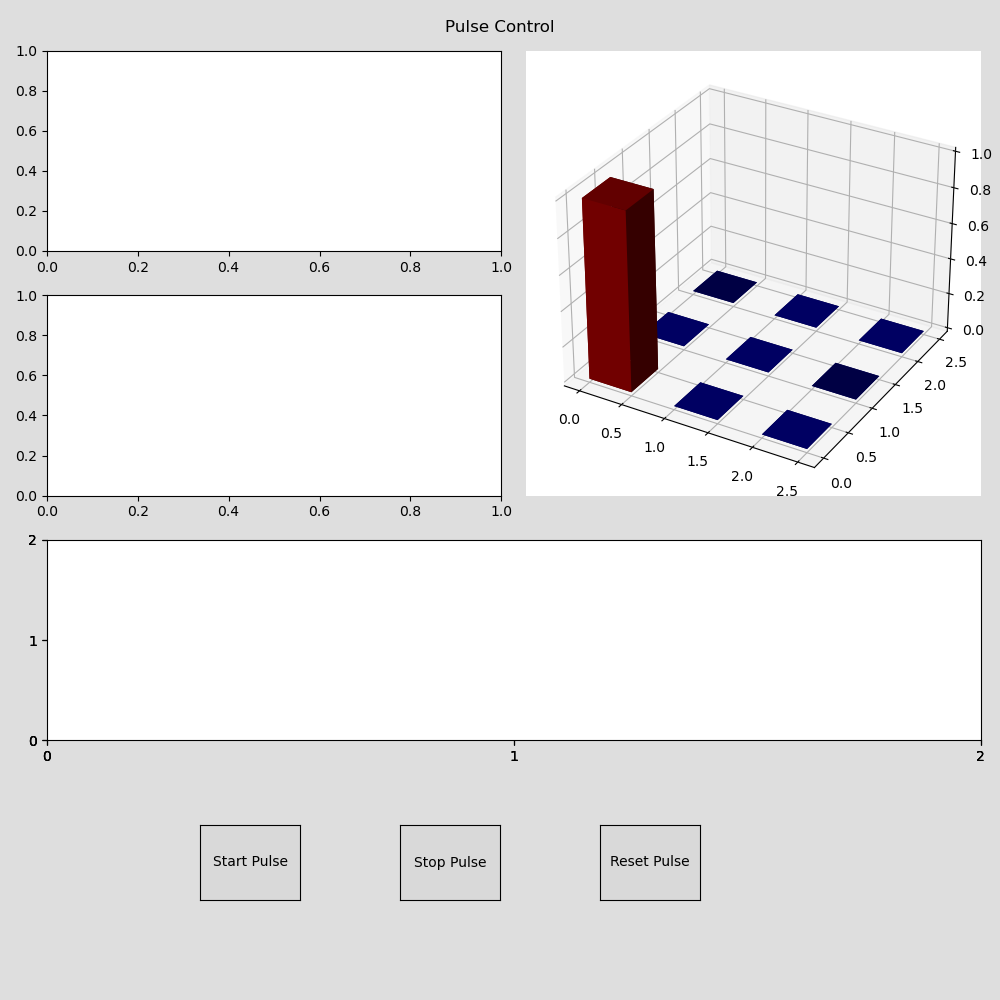

In [5]:
import numpy as np
from numpy.fft import fft
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from qutip import *
from qutip import Bloch
import collections
import random
import time
import threading
from matplotlib.widgets import Button
import matplotlib.image as mpimg

%matplotlib notebook

#qubitパラメータ
f_q = [7500, 8300]
f_anharm = [-380, -400]
f_g = -10


#演算子の定義
N = 3 # 非調和3準位系を考える

a0 = tensor(destroy(N), qeye(N)) # Q1の消滅演算子
a1 = tensor(qeye(N), destroy(N)) # Q2の消滅演算子
a = [a0, a1]

P0_0 = tensor(basis(N,0) * basis(N,0).dag(), qeye(N)) # |0><0|
P1_0 = tensor(basis(N,1) * basis(N,1).dag(), qeye(N)) # |1><1|
Z_0 = P0_0 - P1_0 #sigma_z
X_0 = tensor(basis(N,0) * basis(N,1).dag() + basis(N,1) * basis(N,0).dag(), qeye(N)) #sigma_x
Y_0 = tensor(1j * basis(N,0) * basis(N,1).dag() - 1j * basis(N,1) * basis(N,0).dag(), qeye(N)) #sigma_y

P0_1 = tensor(qeye(N), basis(N,0) * basis(N,0).dag()) # |0><0|
P1_1 = tensor(qeye(N), basis(N,1) * basis(N,1).dag()) # |1><1|
Z_1 = P0_1 - P1_1 #sigma_z
X_1 = tensor(qeye(N), basis(N,0) * basis(N,1).dag() + basis(N,1) * basis(N,0).dag()) #sigma_x
Y_1 = tensor(qeye(N), 1j * basis(N,0) * basis(N,1).dag() - 1j * basis(N,1) * basis(N,0).dag()) #sigma_y

P0 = [P0_0, P0_1]
P1 = [P1_0, P1_1]
Z = [Z_0, Z_1]
X = [X_0, X_1]
Y = [Y_0, Y_1]


"""ハミルトニアン"""

# qubitの自由ハミルトニアン
H_q = []
for i in range(2):
    H_qi = 2*np.pi * f_q[i] * a[i].dag() * a[i] + (2*np.pi*f_anharm[i] / 2) * a[i].dag() * a[i].dag() * a[i] * a[i]
    H_q.append(H_qi)

# 駆動ハミルトニアンの時間無依存部分
H_d = []
for i in range(2):
    H_di = 2*np.pi * (a[i].dag() + a[i])
    H_d.append(H_di)

# 相互作用ハミルトニアン
H_int = 2*np.pi * f_g *(a[0] * a[1].dag() + a[0].dag() * a[1])

t_list = np.linspace(0, 0.2, 10001) # 時間リスト

# 全体のハミルトニアン
def H_tot(f_rabi, f_d, phi, t_list):
    H_tot = [H_q[0] + H_q[1] + H_int, 
             [H_d[0], np.real(f_rabi[0] * np.exp(1j * (2*np.pi * f_d[0] * t_list + phi[0])))], 
             [H_d[1], np.real(f_rabi[1] * np.exp(1j * (2*np.pi * f_d[1] * t_list + phi[1])))]
            ] 
    return H_tot


#リンドブラッド演算子
gamma = [0.1, 0.1]
L_l = []
for i in range(2):
    L_li = np.sqrt(gamma[i]) * a[i] # 縦緩和
    L_l.append(L_li)

gamma_p = [0.3, 0.3]
L_p = []
for i in range(2):
    L_pi = np.sqrt(2*gamma_p[i]) * a[i].dag() * a[i] # 純位相緩和
    L_p.append(L_pi)


# 初期状態
ini_state = tensor(basis(N,0), basis(N,0))   #　|0>|0>

# 密度行列から対角成分を取り出す
def diag_values(psi):
    array = []
    for i in range(len(psi[0][0])):
        array.append((psi[i][0][i]).real)
    return array

# グラフのx軸の単位の設定
#sett = 1 # 1 ns
sett = 10 # 10ns
#sett = 5

%matplotlib widget

qstates = []
count = 0

fig = plt.figure(figsize=(10,10), facecolor='#DEDEDE', tight_layout=True)
fig.suptitle('Pulse Control', fontsize=12)
#fig.add_subplot()

#plt.imshow(img)

# define and adjust figure
gs = fig.add_gridspec(4,4)

pls = fig.add_subplot(gs[2:3, 0:4], facecolor="white")

pls.set_xlim(0, 2000)
pls.set_ylim(0, 380)
pls.axis("off")
#imgplot = plt.imshow(img, extent=(10,60,10,60))
img=mpimg.imread("pulse.jpg")
pls.imshow(img, extent=(80,160,255,335))
pls.text(0,310,"Q0 7.5 GHz")
pls.text(0,210,"Q1 8.3 GHz")
pls.text(80+10,255-15,"π-pulse")
pls.text(210,160-15,"Rx(π/4)-gate")
img=mpimg.imread("pulse.jpg")
pls.imshow(img, extent=(210,290,160,240))


ax1 = fig.add_subplot(gs[0,0:2], facecolor="white") 
ax2 = fig.add_subplot(gs[1,0:2], facecolor="white")  
ax3 = fig.add_subplot(gs[0:2, 2:4], projection='3d')
ax = fig.add_subplot(gs[2:3, 0:4], facecolor="white")
#ax = plt.gca()

#plt.rcParams["figure.figsize"] = [7.00, 3.50]
#plt.rcParams["figure.autolayout"] = True

# 量子状態の初期化
psi = (ini_state.dag()[0][0]).real
psi_upd = []

# 3D ヒストグラム作成
hist = psi
xedges = range(3)
yedges = range(3)
xpos, ypos = np.meshgrid(xedges , yedges, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5 * np.ones_like(zpos)
dz = np.array(hist)

# 3D ヒストグラム カラー指定
cmap = cm.get_cmap('jet') 
max_height = 1.0
min_height = 0.0
rgba = [cmap(k) for k in dz] 

# 3D ヒストグラム プロット
ax3.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba) 
plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])


alist = np.arange(0+count,100+count,1)

# start collections with zeros
ctrl_input_q0_i = collections.deque(np.zeros(100))
ctrl_input_q0_q = collections.deque(np.zeros(100))
ctrl_input_q1_i = collections.deque(np.zeros(100))
ctrl_input_q1_q = collections.deque(np.zeros(100))


#Drive setting
f_rabi = [20, 20] # 振幅
f_d = [0, 0] # 周波数
f_d[0] = f_q[0]
f_d[1] = f_q[1]
phi = [0, 0] # 位相
dt = 0.00004

# Q0-> X Gate
f_rabi = [20, 20] # 振幅
A = f_rabi[0]
f_carrier = f_d[0]
driven_qubit_num = 0

I = [1,0]
Q = [0,0]

duration = 0.027 # 単位: us
dt = 0.00004 # 単位: us
t_list = np.linspace(0, 0 + duration, round(duration/dt)+1)
drive_t_list = np.array(t_list) * np.array([[0 + 0j], [0 + 0j]]) # 初期化

waveform_list = np.array([A * np.exp(1j * phi[0]) for i in t_list])
drive_t_list[driven_qubit_num] = waveform_list * np.exp(1j * 2*np.pi * f_carrier * t_list)    
H_drive = [H_q[0] + H_q[1] + H_int, 
                   [H_d[0], np.real(drive_t_list[0])], 
                   [H_d[1], np.real(drive_t_list[1])]
                  ] 

# round(duration/dt)の標本数のうち50個をプロットする
samples = round(duration/dt)

#ts_f = duration

#Initialize
state = ket2dm(ini_state)

t_now = 0
t_stop = 0
ptime = 0

def my_function(i):
    ax.clear()
    ax.patch.set_alpha(0.5)
    #ax.plot(t,q0, color="gray")
    #ax.plot(t,q1, color="gray")
    #ax.scatter(t_now, 8, color="blue")
    #ax.plot(np.ones(40) * t_now, np.arange(6, 10, 0.1), color="blue")
    ax.set(ylabel=None)
    ax.set(xlabel="time[ns]")
    ax.set_xticks(np.append((np.linspace(0, 1000, 5)),[210,290,80,160]))
    ax.set(yticklabels=[])
    ax.tick_params(left=False)
    ax.set_xlim(0,1000)
    ax.set_ylim(5,11)
    
    if t_now == t_pulse[0][0]-50:
        ax.scatter(t_now, 9 , color="green")
        
    if t_now == t_pulse[1][0]-50:
        ax.scatter(t_now, 7 , color="green")
        
    if t_now == t_pulse[0][0]:
        ax.scatter(t_now, 9 , color="black")
        
    if t_now == t_pulse[1][0]:
        ax.scatter(t_now, 7 , color="black")
        
    # input control
    global qstates, count, qsave, alist
    
    ctrl_input_q0_i.popleft()
    ctrl_input_q0_q.popleft()
    
    ctrl_input_q1_i.popleft()
    ctrl_input_q1_q.popleft()
    
    if len(qstates)>=1:
        ctrl_input_q0_i.append(qstates[0][0])
        ctrl_input_q0_q.append(qstates[0][1])
        
        ctrl_input_q1_i.append(qstates[0][2])
        ctrl_input_q1_q.append(qstates[0][3])
        
        '''q0_state0.append(qstates[0][2])
        q0_state1.append(qstates[0][3])
        q0_state2.append(qstates[0][4])'''
        
        #qsave = (qstates[0][2], qstates[0][3], qstates[0][4])
        qstates = qstates[1:]
    else:
        ctrl_input_q0_i.append(0)
        ctrl_input_q0_q.append(0)
        
        ctrl_input_q1_i.append(0)
        ctrl_input_q1_q.append(0)
    
   
    count += 1
    alist = np.arange(0+count,100+count,1)
    time.sleep(0.015)
        
    # clear axis
    ax1.cla()
    ax2.cla()
    
    ax1.set_title("Input Control Q0")
    ax2.set_title("Input Control Q1")
 
    # plot input1    
    ax1.set_ylim(-1,1)
    ax1.plot(alist/(sett), ctrl_input_q0_i,color="blue", label="I")
    ax1.scatter(alist[-1]/(sett), ctrl_input_q0_i[-1],color="blue")
    
    ax1.plot(alist/(sett), ctrl_input_q0_q,color="red", label="Q")
    ax1.scatter(alist[-1]/(sett), ctrl_input_q0_q[-1],color="red")
    
    if sett == 1:        
        ax1.set_xlabel("time[ns]", {"fontsize":15})
        ax2.set_xlabel("time[ns]", {"fontsize":15})
    else:        
        ax1.set_xlabel("time["+str(sett)+"*ns]", {"fontsize":15})
        ax2.set_xlabel("time["+str(sett)+"*ns]", {"fontsize":15})
        
    ax1.set_ylabel("signal[amp]", {"fontsize":15})
    
    ax1.legend(loc=(0.05, 0.05))
    
    # plot input2
    #ax2.set_ylim(-1,1)
    ax2.set_ylim(-1,1)
    ax2.plot(alist/(sett), ctrl_input_q1_i,color="blue", label="I")
    ax2.scatter(alist[-1]/(sett), ctrl_input_q1_i[-1],color="blue")
    
    ax2.plot(alist/(sett), ctrl_input_q1_q,color="red", label="Q")
    ax2.scatter(alist[-1]/(sett), ctrl_input_q1_q[-1],color="red")
    
    ax2.set_ylabel("signal[amp]", {"fontsize":15})
    
    ax2.legend(loc=(0.05, 0.05))
    
    global atime, psi_upd
    if len(psi_upd)>0:
        ax3.clear()
        dz = psi_upd[0]
        cmap = cm.get_cmap('jet')
        
        rgba = [cmap(k) for k in dz] 
        ax3.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba) 
        ax3.set_zlim(0,1.0)
        plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
        plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])
        
        psi_upd = psi_upd[1:]
        #time.sleep(0.4)
    
    

class Index:
    ind = 0

    def pulse_start(self, event):
        global t_stop
        t_stop = 0
        threading.Thread(target=start).start()
        
    def pulse_stop(self, event):
        global t_stop
        t_stop = 1
        #threading.Thread(target=pulse_stop).start()
        
    def pulse_reset(self, event):
        global t_stop, t_now
        t_stop = 1
        t_now = 0
        
def start():
    #for i in range(10):        
    global t_now, t_stop, ptime
    t_start = t_now
    while t_now < 1000 and t_stop==0:
        ptime = t_now
        time.sleep(0.1)
        t_now += 1
        #t_now += 2
        #t_now += 5
        #t_now += 10

#ax.set_xlim(0, 300)
#ax.set_ylim(0, 300)
#img=mpimg.imread("pulse.jpg")
#ax.imshow(img, extent=(10,160,10,160))

t = np.arange(0, 1000, 1)
q0 = np.ones(1000)*9
q1 = np.ones(1000)*7

callback = Index()

ax4 = fig.add_axes([0.2, 0.1, 0.1, 0.075])
ax5 = fig.add_axes([0.4, 0.1, 0.1, 0.075])
ax6 = fig.add_axes([0.6, 0.1, 0.1, 0.075])
b1 = Button(ax4, 'Start Pulse')
b1.on_clicked(callback.pulse_start)
b2 = Button(ax5, 'Stop Pulse')
b2.on_clicked(callback.pulse_stop)
b3 = Button(ax6, 'Reset Pulse')
b3.on_clicked(callback.pulse_reset)


# animate
ani = FuncAnimation(fig, my_function, interval=50)

plt.show()

In [ ]:
ptime

In [ ]:
log

In [3]:
t_pulse = []
t_pulse.append([310,1,0.054,10])
t_pulse.append([180,0,0.027,20])
t_pulse.append([500,0,0.027,20])
t_pulse.append([600,1,0.033,50])
t_pulse.sort()
log = 0

def pulse_manager():
    global state, t_pulse, alist, result, psi_upd, sett, qstates
    start = alist[-1]
    global ptime
    global log
    #ptime = 0
    samples = 0
    pulse_counter = 0
    ptime_reg=0
    while(True):
        if ptime_reg > ptime:
            pulse_counter = 0
        ptime_reg = ptime
        if(start==alist[-1]):
            if pulse_counter < len(t_pulse):
                if ptime == t_pulse[pulse_counter][0]-10:
                    if t_pulse[pulse_counter][1] == 0: #Q0?
                        I = [1,0]
                        Q = [0,0]
                        f_carrier = f_d[0]
                        driven_qubit_num = 0
                    elif t_pulse[pulse_counter][1] == 1: #Q1?
                        I = [0,1]
                        Q = [0,0]
                        f_carrier = f_d[1]
                        driven_qubit_num = 1
                    duration =  t_pulse[pulse_counter][2]
                    samples = round(duration/dt)
                    A =  t_pulse[pulse_counter][3]
                    t_list = np.linspace(0, 0 + duration, round(duration/dt)+1)
                    drive_t_list = np.array(t_list) * np.array([[0 + 0j], [0 + 0j]]) # 初期化
                    waveform_list = np.array([A * np.exp(1j * phi[0]) for i in t_list])
                    drive_t_list[driven_qubit_num] = waveform_list * np.exp(1j * 2*np.pi * f_carrier * t_list)  
                    H_drive = [H_q[0] + H_q[1] + H_int, 
                       [H_d[0], np.real(drive_t_list[0])], 
                       [H_d[1], np.real(drive_t_list[1])]
                      ]
                    result = mesolve(H_drive, state, t_list, [])
                    state = result.states[-1]
                if ptime == t_pulse[pulse_counter][0]:
                    for i in range(0,samples+1,sett):
                        log+=1
                        psi_upd.append(diag_values(result.states[i]))
                        #psi_upd.append([0+i/samples,0,0,0+i/samples,0,0,0,0+i/samples,0])
                        qstates.append([(I[0]*np.sin(2*np.pi*i*f_d[0]*(duration/(samples*10)) + phi[0])),(Q[0]*np.cos(2*np.pi*i*f_d[0]*(duration/(samples*10)) + phi[0])), (I[1]*np.sin(2*np.pi*i*f_d[1]*(duration/(samples*10)) + phi[1])),(Q[1]*np.cos(2*np.pi*i*f_d[1]*(duration/(samples*10)) + phi[1]))]) 
                        #stop = 1
                    pulse_counter += 1
            start += 1
            #ptime += 1
        else:
            time.sleep(0.05)
            #if alist[-1] > tp+10:
                #stop = 1

In [4]:
threading.Thread(target=pulse_manager).start()

In [ ]:
                        psi_upd.append(diag_values(result.states[i]))
                        #psi_upd.append([0+i/samples,0,0,0+i/samples,0,0,0,0+i/samples,0])
                        qstates.append([(I[0]*np.sin(2*np.pi*i*f_d[0]*(duration/(samples*10)) + phi[0])),(Q[0]*np.cos(2*np.pi*i*f_d[0]*(duration/(samples*10)) + phi[0])), (I[1]*np.sin(2*np.pi*i*f_d[1]*(duration/(samples*10)) + phi[1])),(Q[1]*np.cos(2*np.pi*i*f_d[1]*(duration/(samples*10)) + phi[1]))]) 
                        #stop = 1

C:\Users\nilton\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.figure.savefig(buf, format='png', dpi='figure')


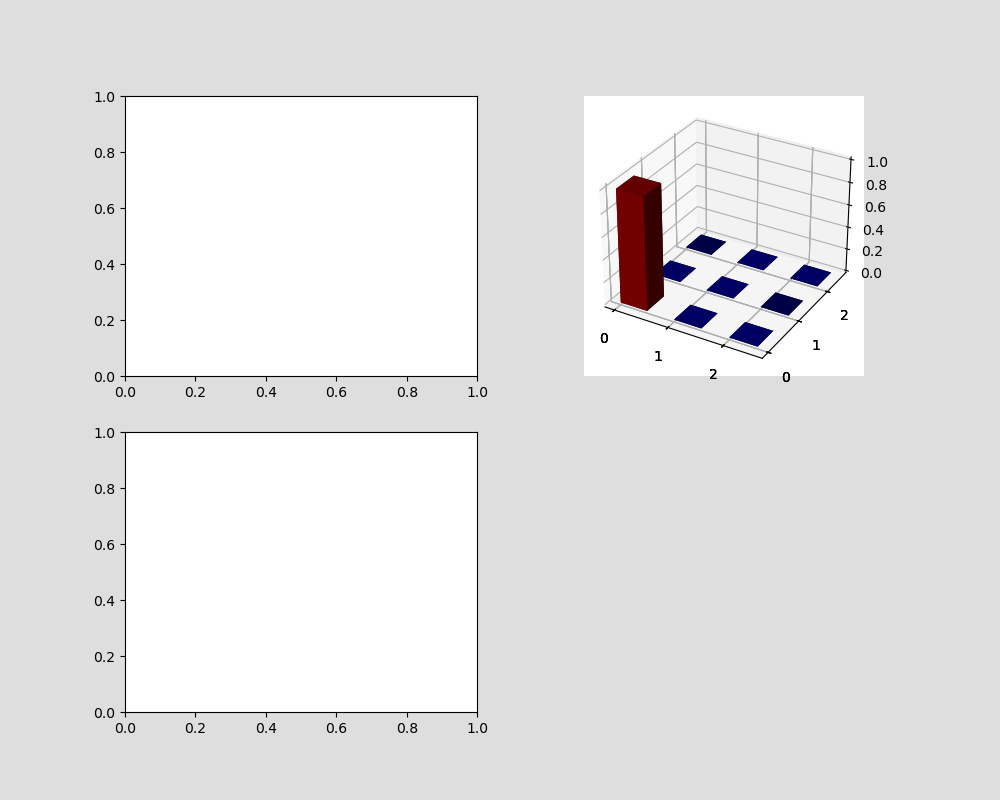

In [1]:
import numpy as np
from numpy.fft import fft
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from qutip import *
from qutip import Bloch
import collections
import random
import time
import threading

#qubitパラメータ
f_q = [7500, 8300]
f_anharm = [-380, -400]
f_g = -10


#演算子の定義
N = 3 # 非調和3準位系を考える

a0 = tensor(destroy(N), qeye(N)) # Q1の消滅演算子
a1 = tensor(qeye(N), destroy(N)) # Q2の消滅演算子
a = [a0, a1]

P0_0 = tensor(basis(N,0) * basis(N,0).dag(), qeye(N)) # |0><0|
P1_0 = tensor(basis(N,1) * basis(N,1).dag(), qeye(N)) # |1><1|
Z_0 = P0_0 - P1_0 #sigma_z
X_0 = tensor(basis(N,0) * basis(N,1).dag() + basis(N,1) * basis(N,0).dag(), qeye(N)) #sigma_x
Y_0 = tensor(1j * basis(N,0) * basis(N,1).dag() - 1j * basis(N,1) * basis(N,0).dag(), qeye(N)) #sigma_y

P0_1 = tensor(qeye(N), basis(N,0) * basis(N,0).dag()) # |0><0|
P1_1 = tensor(qeye(N), basis(N,1) * basis(N,1).dag()) # |1><1|
Z_1 = P0_1 - P1_1 #sigma_z
X_1 = tensor(qeye(N), basis(N,0) * basis(N,1).dag() + basis(N,1) * basis(N,0).dag()) #sigma_x
Y_1 = tensor(qeye(N), 1j * basis(N,0) * basis(N,1).dag() - 1j * basis(N,1) * basis(N,0).dag()) #sigma_y

P0 = [P0_0, P0_1]
P1 = [P1_0, P1_1]
Z = [Z_0, Z_1]
X = [X_0, X_1]
Y = [Y_0, Y_1]


"""ハミルトニアン"""

# qubitの自由ハミルトニアン
H_q = []
for i in range(2):
    H_qi = 2*np.pi * f_q[i] * a[i].dag() * a[i] + (2*np.pi*f_anharm[i] / 2) * a[i].dag() * a[i].dag() * a[i] * a[i]
    H_q.append(H_qi)

# 駆動ハミルトニアンの時間無依存部分
H_d = []
for i in range(2):
    H_di = 2*np.pi * (a[i].dag() + a[i])
    H_d.append(H_di)

# 相互作用ハミルトニアン
H_int = 2*np.pi * f_g *(a[0] * a[1].dag() + a[0].dag() * a[1])

t_list = np.linspace(0, 0.2, 10001) # 時間リスト

# 全体のハミルトニアン
def H_tot(f_rabi, f_d, phi, t_list):
    H_tot = [H_q[0] + H_q[1] + H_int, 
             [H_d[0], np.real(f_rabi[0] * np.exp(1j * (2*np.pi * f_d[0] * t_list + phi[0])))], 
             [H_d[1], np.real(f_rabi[1] * np.exp(1j * (2*np.pi * f_d[1] * t_list + phi[1])))]
            ] 
    return H_tot


#リンドブラッド演算子
gamma = [0.1, 0.1]
L_l = []
for i in range(2):
    L_li = np.sqrt(gamma[i]) * a[i] # 縦緩和
    L_l.append(L_li)

gamma_p = [0.3, 0.3]
L_p = []
for i in range(2):
    L_pi = np.sqrt(2*gamma_p[i]) * a[i].dag() * a[i] # 純位相緩和
    L_p.append(L_pi)


# 初期状態
ini_state = tensor(basis(N,0), basis(N,0))   #　|0>|0>

# 密度行列から対角成分を取り出す
def diag_values(psi):
    array = []
    for i in range(len(psi[0][0])):
        array.append((psi[i][0][i]).real)
    return array

# グラフのx軸の単位の設定
#sett = 1 # 1 ns
sett = 10 # 10ns
#sett = 5

%matplotlib widget

qstates = []
count = 0

fig = plt.figure(figsize=(10,8), facecolor='#DEDEDE', tight_layout=True)

# define and adjust figure
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0,0], facecolor="white") 
ax2 = fig.add_subplot(gs[1,0], facecolor="white")  
ax3 = fig.add_subplot(gs[0:1, 1:2], projection='3d')  

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

# 量子状態の初期化
psi = (ini_state.dag()[0][0]).real
psi_upd = []

# 3D ヒストグラム作成
hist = psi
xedges = range(3)
yedges = range(3)
xpos, ypos = np.meshgrid(xedges , yedges, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5 * np.ones_like(zpos)
dz = np.array(hist)

# 3D ヒストグラム カラー指定
cmap = cm.get_cmap('jet') 
max_height = 1.0
min_height = 0.0
rgba = [cmap(k) for k in dz] 

# 3D ヒストグラム プロット
ax3.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba) 
plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])


alist = np.arange(0+count,100+count,1)
    

def my_function(i):
    # input control
    global qstates, count, qsave, alist
    
    ctrl_input_q0_i.popleft()
    ctrl_input_q0_q.popleft()
    
    ctrl_input_q1_i.popleft()
    ctrl_input_q1_q.popleft()
    
    if len(qstates)>=1:
        ctrl_input_q0_i.append(qstates[0][0])
        ctrl_input_q0_q.append(qstates[0][1])
        
        ctrl_input_q1_i.append(qstates[0][2])
        ctrl_input_q1_q.append(qstates[0][3])
        
        '''q0_state0.append(qstates[0][2])
        q0_state1.append(qstates[0][3])
        q0_state2.append(qstates[0][4])'''
        
        #qsave = (qstates[0][2], qstates[0][3], qstates[0][4])
        qstates = qstates[1:]
    else:
        ctrl_input_q0_i.append(0)
        ctrl_input_q0_q.append(0)
        
        ctrl_input_q1_i.append(0)
        ctrl_input_q1_q.append(0)
    
   
    count += 1
    alist = np.arange(0+count,100+count,1)
    time.sleep(0.015)
        
    # clear axis
    ax1.cla()
    ax2.cla()
    
    ax1.set_title("Input Control Q0")
    ax2.set_title("Input Control Q1")
 
    # plot input1    
    ax1.set_ylim(-1,1)
    ax1.plot(alist/(sett), ctrl_input_q0_i,color="blue", label="I")
    ax1.scatter(alist[-1]/(sett), ctrl_input_q0_i[-1],color="blue")
    
    ax1.plot(alist/(sett), ctrl_input_q0_q,color="red", label="Q")
    ax1.scatter(alist[-1]/(sett), ctrl_input_q0_q[-1],color="red")
    
    if sett == 1:        
        ax1.set_xlabel("time[ns]", {"fontsize":15})
        ax2.set_xlabel("time[ns]", {"fontsize":15})
    else:        
        ax1.set_xlabel("time["+str(sett)+"*ns]", {"fontsize":15})
        ax2.set_xlabel("time["+str(sett)+"*ns]", {"fontsize":15})
        
    ax1.set_ylabel("signal[amp]", {"fontsize":15})
    
    ax1.legend(loc=(0.05, 0.05))
    
    # plot input2
    #ax2.set_ylim(-1,1)
    ax2.set_ylim(-1,1)
    ax2.plot(alist/(sett), ctrl_input_q1_i,color="blue", label="I")
    ax2.scatter(alist[-1]/(sett), ctrl_input_q1_i[-1],color="blue")
    
    ax2.plot(alist/(sett), ctrl_input_q1_q,color="red", label="Q")
    ax2.scatter(alist[-1]/(sett), ctrl_input_q1_q[-1],color="red")
    
    ax2.set_ylabel("signal[amp]", {"fontsize":15})
    
    ax2.legend(loc=(0.05, 0.05))
    
    global atime, psi_upd
    if len(psi_upd)>0:
        ax3.clear()
        dz = psi_upd[0]
        cmap = cm.get_cmap('jet')
        
        rgba = [cmap(k) for k in dz] 
        ax3.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba) 
        ax3.set_zlim(0,1.0)
        plt.xticks(xpos, ["0","0","0","1","1","1","2","2","2"])
        plt.yticks(ypos, ["0","1","2","0","1","2","0","1","2"])
        
        psi_upd = psi_upd[1:]
        #time.sleep(0.4)

# start collections with zeros
ctrl_input_q0_i = collections.deque(np.zeros(100))
ctrl_input_q0_q = collections.deque(np.zeros(100))
ctrl_input_q1_i = collections.deque(np.zeros(100))
ctrl_input_q1_q = collections.deque(np.zeros(100))

# animate

ani = FuncAnimation(fig, my_function, interval=10)
plt.show()

#Drive setting
f_rabi = [20, 20] # 振幅
f_d = [0, 0] # 周波数
f_d[0] = f_q[0]
f_d[1] = f_q[1]
phi = [0, 0] # 位相
dt = 0.00004

# Q0-> X Gate
f_rabi = [20, 20] # 振幅
A = f_rabi[0]
f_carrier = f_d[0]
driven_qubit_num = 0

I = [1,0]
Q = [0,0]

duration = 0.027 # 単位: us
dt = 0.00004 # 単位: us
t_list = np.linspace(0, 0 + duration, round(duration/dt)+1)
drive_t_list = np.array(t_list) * np.array([[0 + 0j], [0 + 0j]]) # 初期化

waveform_list = np.array([A * np.exp(1j * phi[0]) for i in t_list])
drive_t_list[driven_qubit_num] = waveform_list * np.exp(1j * 2*np.pi * f_carrier * t_list)    
H_drive = [H_q[0] + H_q[1] + H_int, 
                   [H_d[0], np.real(drive_t_list[0])], 
                   [H_d[1], np.real(drive_t_list[1])]
                  ] 

# round(duration/dt)の標本数のうち50個をプロットする
samples = round(duration/dt)

#ts_f = duration

#Initialize
state = ket2dm(ini_state)